In [1]:
import os

import torch
from hydra import compose, initialize
from torch.utils.data import DataLoader

from src.components.cdvi import load_from_cfg
from src.utils.eval import (create_grid, eval_dist_on_grid, eval_kde_on_grid, eval_hist_on_grid,
                            normalize_vals_on_grid, compute_bd, compute_jsd)
from src.utils.visualize import (visualize_cdvi_for_bml,
                                 visualize_vals_on_grid_2d)

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 
print(device)

privateuseone:0


In [3]:
dir = "../models/serene-meadow-9"

In [4]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="config")

    cdvi, dataloader, _ = load_from_cfg(cfg, device)

    path = f"{dir}/cdvi.pth"

    if os.path.exists(path):
        state_dict = torch.load(path, map_location=torch.device("cpu"), weights_only=True)
        cdvi.load_state_dict(state_dict)
        print(f"loaded cdvi from {path}")

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 281993.16it/s]


loaded cdvi from ../models/serene-meadow-9/cdvi.pth


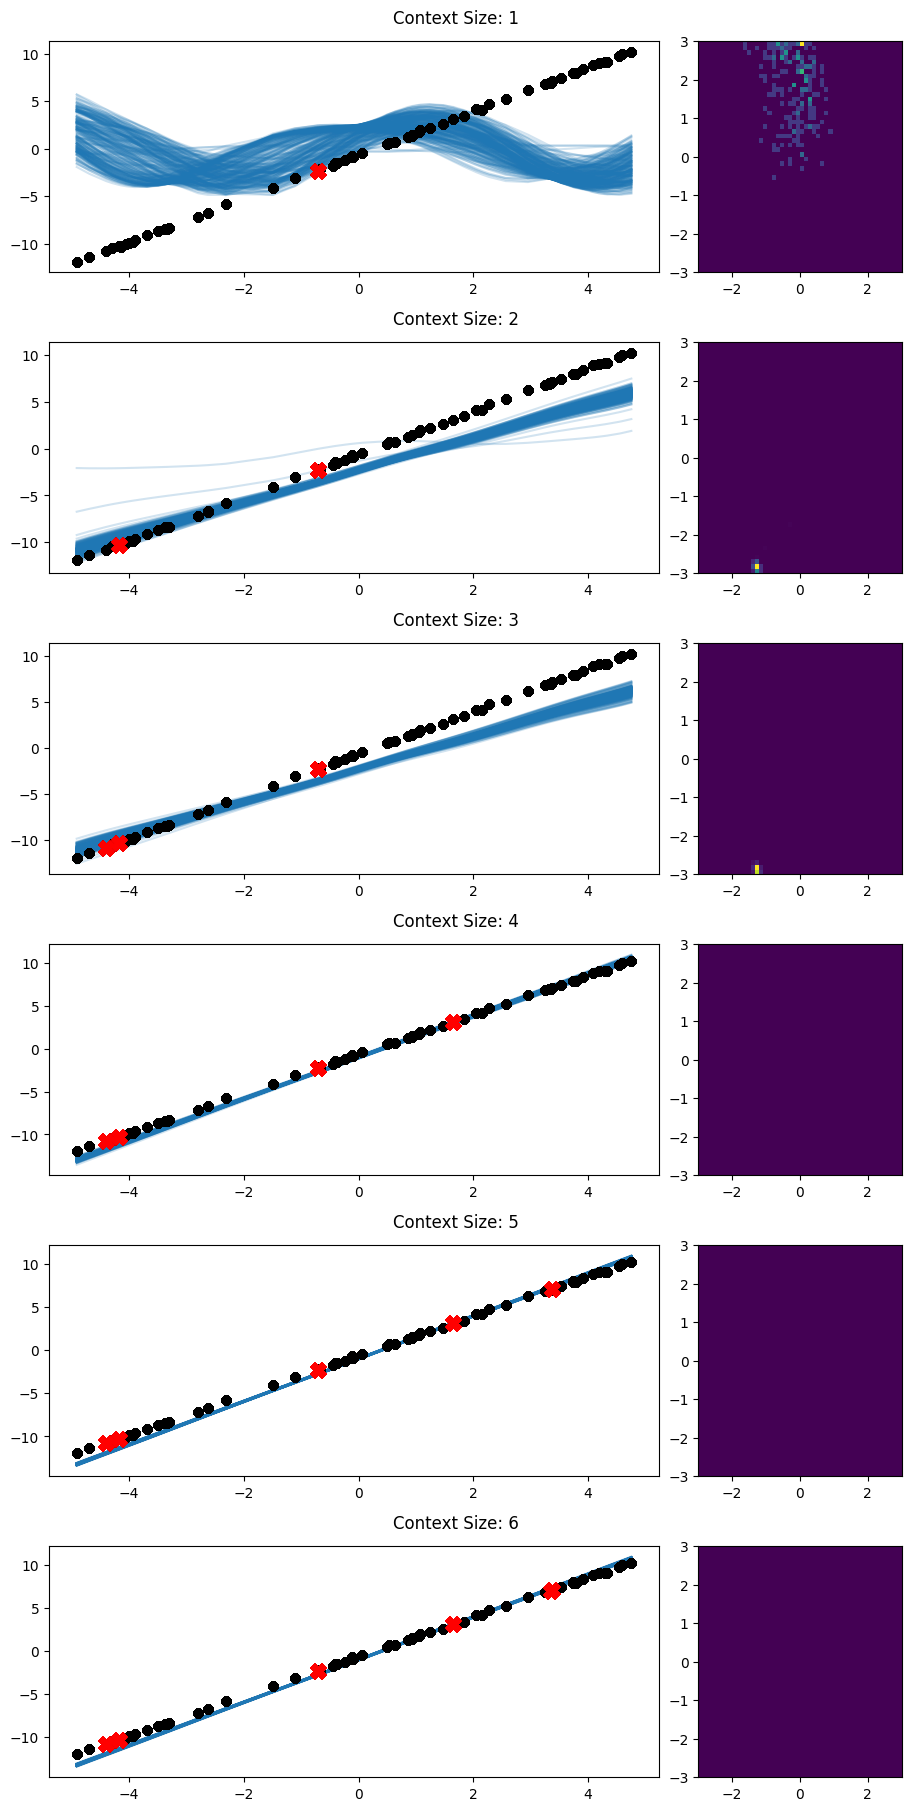

In [7]:
max_context_size = 6
num_samples = 256
gen_dataloader = DataLoader(dataloader.dataset, 1, True)

targets, samples = visualize_cdvi_for_bml(
    device=device,
    cdvi=cdvi,
    dataloader=gen_dataloader,
    config=cfg,
    num_samples=num_samples,
    max_context_size=max_context_size
)

jsd: 1.2758614469726326 bd: 1.0801043344032522


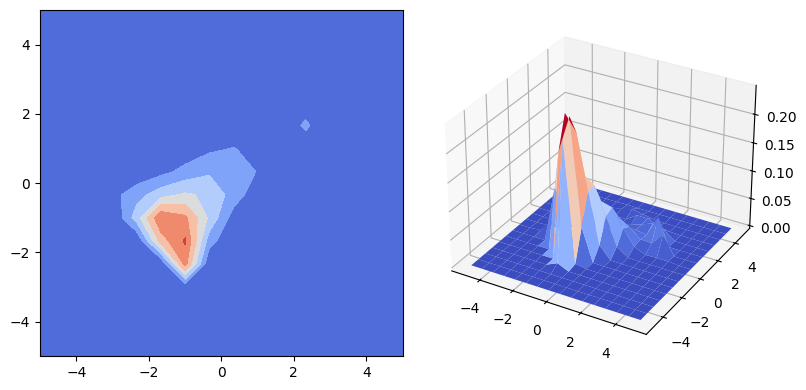

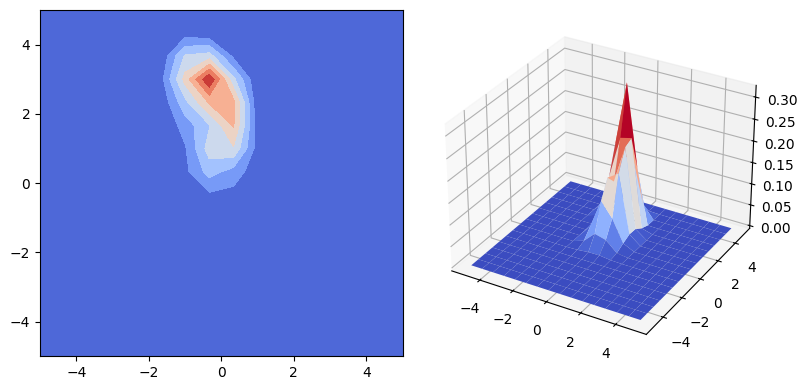

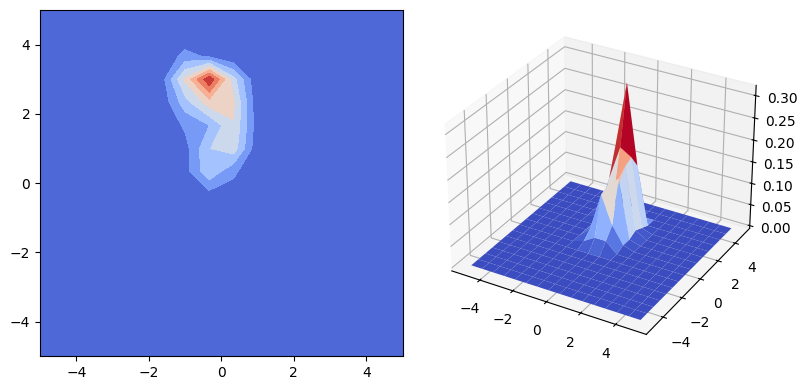

jsd: 1.7744566838992486 bd: 15.858001831621472


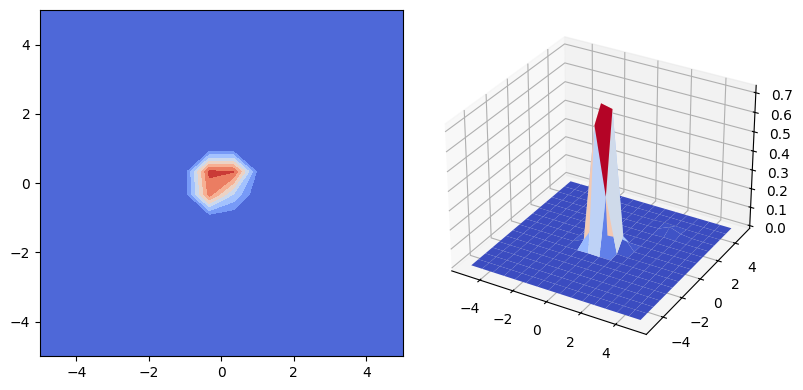

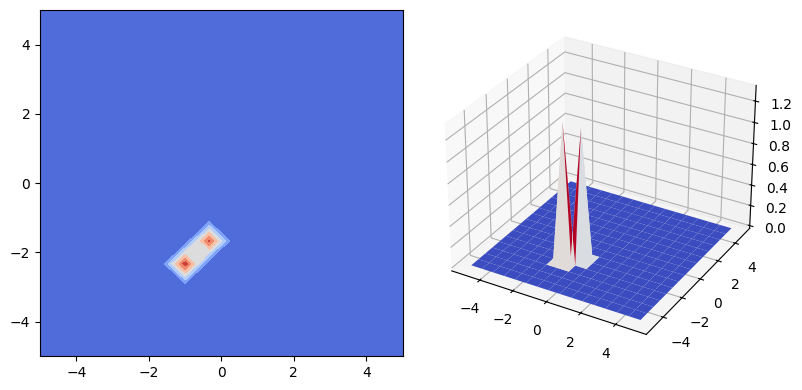

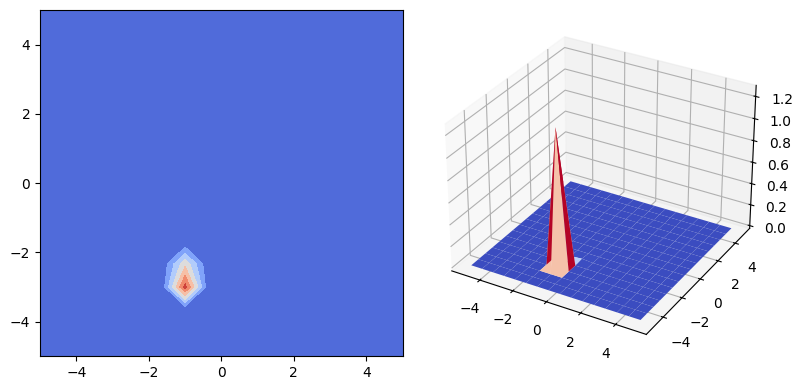

jsd: 1.7744567815692722 bd: 23.418267381335962


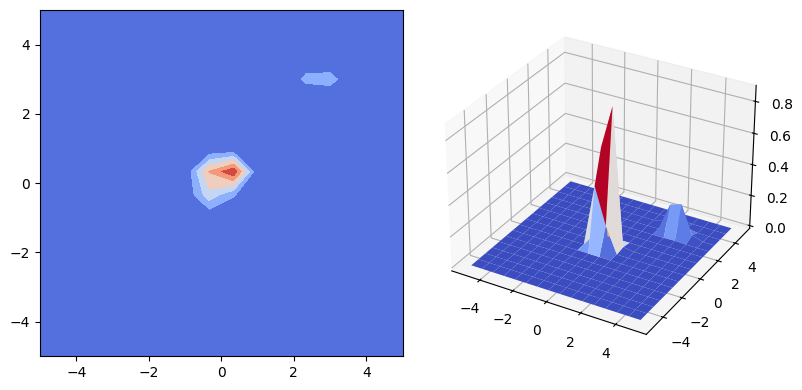

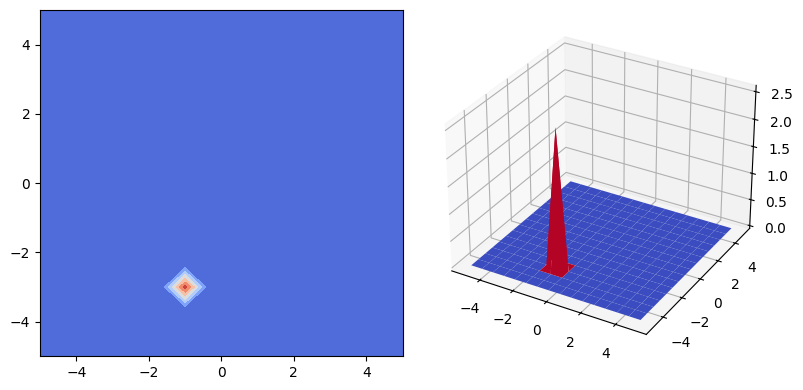

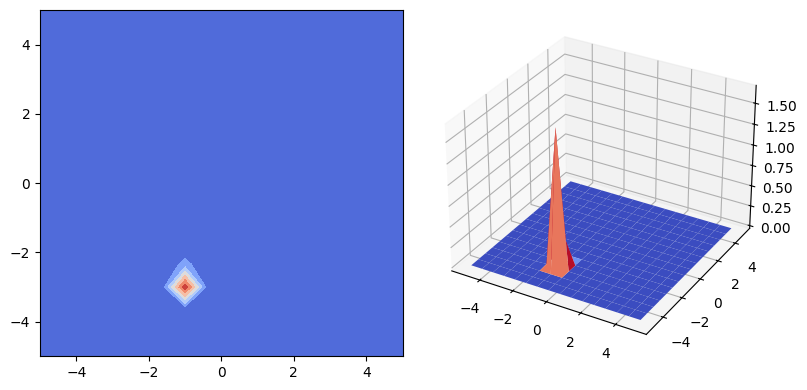

jsd: 1.7744567667672824 bd: inf


/home/chickencurry/dvi-for-bml/src/utils/eval.py:112: RuntimeWarning: divide by zero encountered in log
  bd = -np.log(bc)


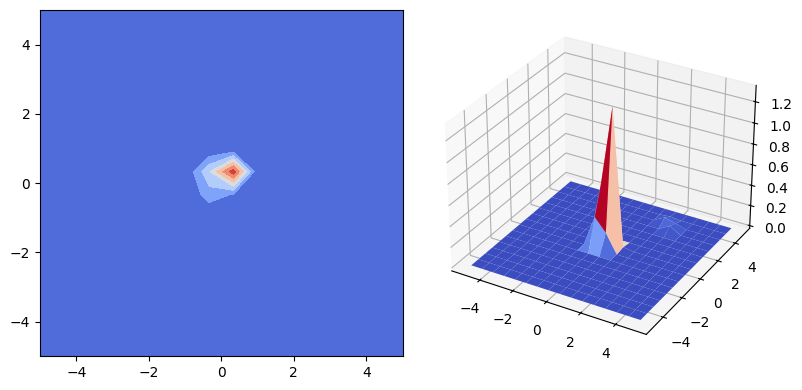

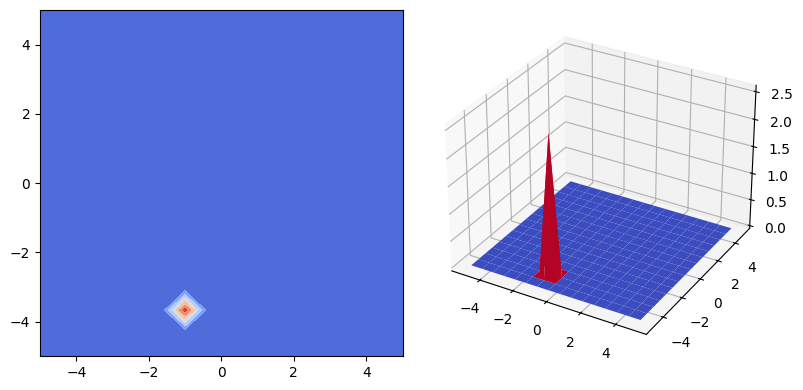

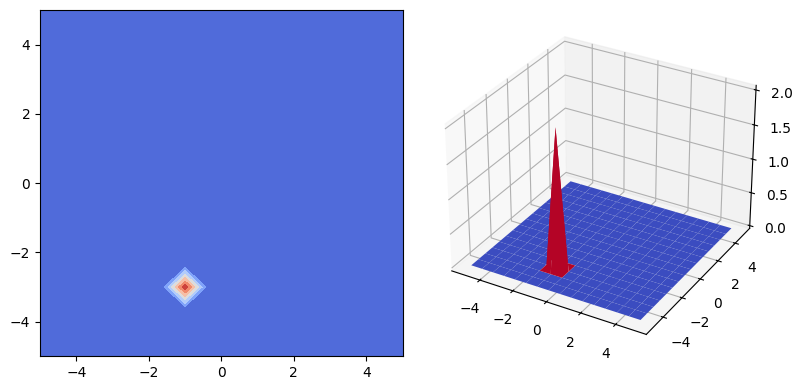

jsd: 0.8872284027204171 bd: inf


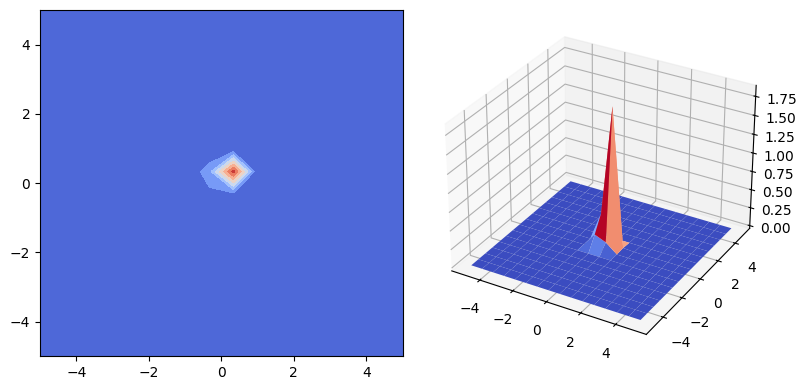

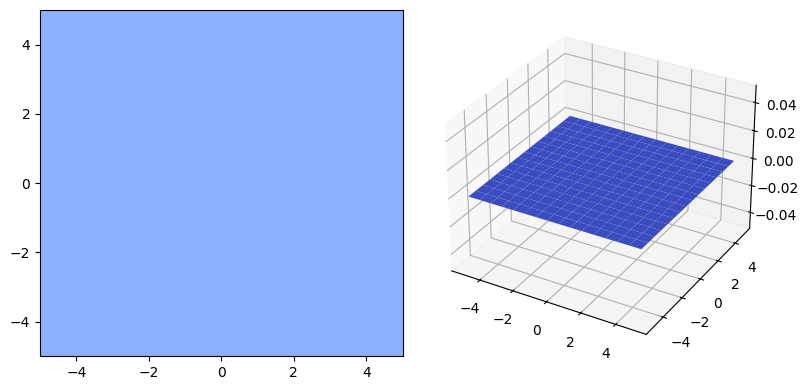

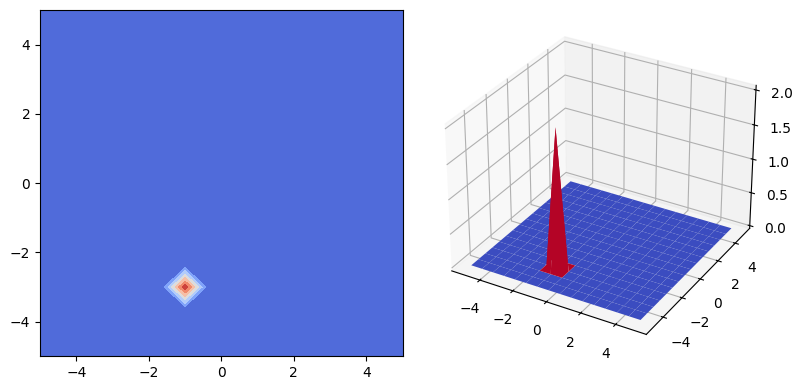

jsd: 0.8872284950468556 bd: inf


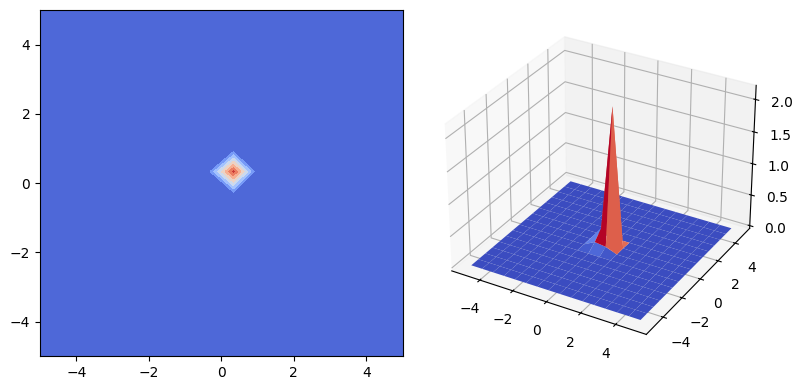

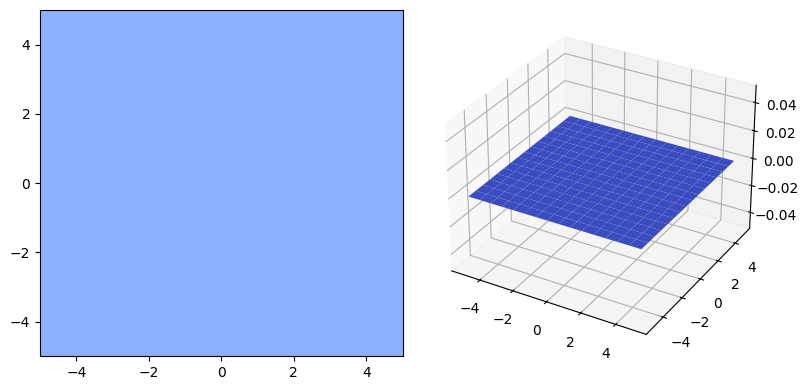

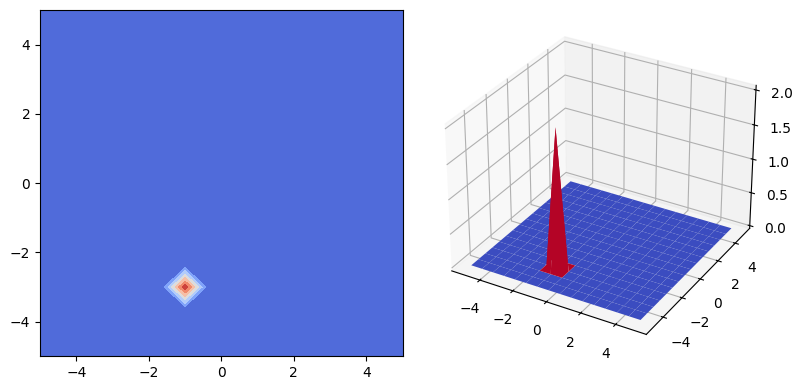

In [ ]:
intervals = [(-5, 5), (-5, 5)]
num = 16
grid = create_grid(intervals, num)

for i in range(len(targets)):
    target_vals = eval_dist_on_grid(grid, targets[i], device=device)
    target_vals = normalize_vals_on_grid(target_vals, intervals, num)

    dvi_vals = eval_kde_on_grid(grid, samples[i])
    dvi_vals = normalize_vals_on_grid(dvi_vals, intervals, num)
    dvi_2_vals = eval_hist_on_grid(samples[i], intervals, num)

    jsd = compute_jsd(target_vals, dvi_vals)
    bd = compute_bd(target_vals, dvi_vals)

    print(f"jsd: {jsd}", f"bd: {bd}")

    visualize_vals_on_grid_2d(grid, target_vals)
    visualize_vals_on_grid_2d(grid, dvi_vals)
    visualize_vals_on_grid_2d(grid, dvi_2_vals)